<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Settings" data-toc-modified-id="Settings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Variables" data-toc-modified-id="Variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Variables</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Equations" data-toc-modified-id="Equations-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Equations</a></span></li><li><span><a href="#Compile-Model" data-toc-modified-id="Compile-Model-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Compile Model</a></span></li></ul></li><li><span><a href="#Calibration" data-toc-modified-id="Calibration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calibration</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Check-calibration" data-toc-modified-id="Check-calibration-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Check calibration</a></span></li></ul></li></ul></li><li><span><a href="#Simulations" data-toc-modified-id="Simulations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulations</a></span></li></ul></div>

In [107]:
import numpy as np

x = np.tril(np.random.normal(size=(3, 3)))
L = np.linalg.cholesky(np.dot(x, x.T))
print(np.allclose(x @ x.T, L @ L.T)) # True

True


In [109]:
np.linalg.eigvals(x)

array([ 0.99392308, -1.37118724, -1.31342251])

In [111]:
np.linalg.eigvals(L)

array([0.99392308, 1.37118724, 1.31342251])

In [1]:
import sympy as sp
import numpy as np
import numba as nb
from scipy import optimize
import sys
from functools import partial

sys.path.append('..')

from cge_modeling.sympy_tools import info_to_symbols, enumerate_indexbase, sub_all_eqs, dict_info_to_symbols, symbol, symbols, remove_string_keys
from cge_modeling.production_functions import leontief, cobb_douglass
from cge_modeling.cge import compile_cge_to_numba, expand_compact_system, recursive_solve_symbolic, numba_linearize_cge_func
from cge_modeling.numba_tools import euler_approx, numba_lambdify
from cge_modeling.output_tools import display_info_as_table, latex_print_equations

import pandas as pd

# Data

In [2]:
df = (pd.read_csv('data/lesson_5_sam.csv', index_col=[0, 1], header=[0, 1])
         .applymap(float)
         .fillna(0))
assert np.allclose(df.sum(axis=0), df.sum(axis=1))

C:\Users\Jesse\AppData\Local\Temp\ipykernel_316\933011678.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(float)


In [3]:
df

Factor         Institution                  \
                                   Labor Capital   Household   Firms    Govt   
Factor      Labor                    0.0     0.0         0.0     0.0     0.0   
            Capital                  0.0     0.0         0.0     0.0     0.0   
Institution Household             6950.0     0.0         0.0  2600.0     0.0   
            Firms                    0.0  2600.0         0.0     0.0     0.0   
            Govt                     0.0     0.0      1400.0     0.0     0.0   
Production  Agriculture              0.0     0.0      1700.0     0.0   400.0   
            Industry                 0.0     0.0      1200.0     0.0   900.0   
            Services                 0.0     0.0      3400.0     0.0  2750.0   
Activities  Agriculture              0.0     0.0         0.0     0.0     0.0   
            Industry                 0.0     0.0         0.0     0.0     0.0   
            Services                 0.0     0.0         0.0     0.0     0.0   
Other       Capital Accumulation     0.0     0.0      1850.0     0.0  -900.0   
            Rest of World            0.0     0.0         0.0     0.0     0.0   

                                  Production                    Activities  \
                                 Agriculture Industry Services Agriculture   
Factor      Labor                        0.0      0.0      0.0      1100.0   
            Capital                      0.0      0.0      0.0       250.0   
Institution Household                    0.0      0.0      0.0         0.0   
            Firms                        0.0      0.0      0.0         0.0   
            Govt                       150.0   1320.0    280.0         0.0   
Production  Agriculture                  0.0      0.0      0.0      1100.0   
            Industry                     0.0      0.0      0.0      2200.0   
            Services                     0.0      0.0      0.0       850.0   
Activities  Agriculture               5500.0      0.0      0.0         0.0   
            Industry                     0.0   9800.0      0.0         0.0   
            Services                     0.0      0.0  10200.0         0.0   
Other       Capital Accumulation         0.0      0.0      0.0         0.0   
            Rest of World                0.0    430.0      0.0         0.0   

                                                                  Other  \
                                 Industry Services Capital Accumulation   
Factor      Labor                  1700.0   4150.0                  0.0   
            Capital                1800.0    550.0                  0.0   
Institution Household                 0.0      0.0                  0.0   
            Firms                     0.0      0.0                  0.0   
            Govt                      0.0      0.0                  0.0   
Production  Agriculture             900.0   1100.0                200.0   
            Industry               3150.0   3300.0                800.0   
            Services               2250.0   1100.0                100.0   
Activities  Agriculture               0.0      0.0                  0.0   
            Industry                  0.0      0.0                  0.0   
            Services                  0.0      0.0                  0.0   
Other       Capital Accumulation      0.0      0.0                  0.0   
            Rest of World             0.0      0.0                  0.0   

                                                
                                 Rest of World  
Factor      Labor                          0.0  
            Capital                        0.0  
Institution Household                      0.0  
            Firms                          0.0  
            Govt                           0.0  
Production  Agriculture                  250.0  
            Industry                       0.0  
            Services                      30.0  
Activities  Agriculture                    0.0

# Model

## Settings

In [4]:
default_assumptions = {'real':True}
sectors = ['Ag', 'Ind', 'Serv']
nm1_sectors = len(sectors) - 1

i, j = [sp.Idx(name) for name in list('ij')]
index_dict = {
    i:sectors,
    j:sectors
}

symbol = partial(symbol, assumptions=default_assumptions)
symbols = partial(symbols, assumptions=default_assumptions)

## Variables

In [5]:
from cge_modeling.cge import Variable

In [52]:
type(Y)

sympy.tensor.indexed.IndexedBase

In [53]:
type(Y[i])

sympy.tensor.indexed.Indexed

In [98]:
Y_base, C_base = [sp.IndexedBase(name) for name in ['Y', 'C']]
i = sp.Idx('i')
Y, C, a, b = sp.symbols('Y C a b')
var_dict = {var.name:var for var in [Y_base, C_base, a, b, i]}
known_symbols = [Y, C, a, b, Y_base[i], C_base[i], i]

def sympify_plus(expr, var_dict, known_symbols):
    if '=' in expr:
        if expr.count('=') > 1:
            raise ValueError('Cannot parse expression with multiple equality relationships')
        lhs, rhs = [x.strip() for x in expr.split('=')]
        eq = sp.Eq(sp.sympify(lhs, locals=var_dict), sp.sympify(rhs, locals=var_dict))
    else:
        eq = expr.sympify(expr, locals=var_dict)
    
    unknown_symbols = [x for x in eq.free_symbols if x not in known_symbols]
    atom_list = ', '.join([x.name for x in unknown_symbols])
    if len(unknown_symbols) > 0:
        raise ValueError('Found unknown variables in parsed expression. Ensure the following have been added to your '
                         f'model: {atom_list}')
        
    return eq

eq = sympify_plus('Y[i] = a + b * C[i]', var_dict, known_symbols)

In [99]:
eq

Eq(Y[i], a + b*C[i])

In [93]:
[(x.name, x in known_symbols) for x in eq.lhs.free_symbols]

[('Y[i]', True), ('i', True), ('Y', False)]

In [65]:
sp.parse_expr('Y[i] - a + b * C', {'Y':sp.IndexedBase('Y')})

C*b - a + Y[i]

In [58]:
eq.free_symbols

{C, Y, a, b}

In [34]:
eq.

C:\Users\Jesse\AppData\Local\Temp\ipykernel_316\384169425.py:1: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  eq.expr_free_symbols


set()

In [6]:
# 24 equations (Really 27, because 3 values are fixed)
variable_info = [
    # Firm variables
    Variable(name='Y',  index=(i, ), latex_name='Y_{i}',  description='Total output of final goods in sector i'),
    Variable(name='VA', index=(i, ), latex_name='VA_{i}', description='Labor-Capital input mix used for final goods production in sector i'),
    Variable(name='IC', index=(i, ), latex_name='IC_{i}', description='Final goods input mix usef for final goods production in sector i'),
    Variable(name='Kd', index=(i, ), latex_name='K^d_i',  description='Quantity of capital demanded by sector i'),
    Variable(name='Ld', index=(i, ), latex_name='L^d_i',  description='Quantity of labor demanded by sector i'),
    Variable(name='CIJ', index=(i, j), latex_name='Y^d_{i,j}', description='Quantity of sector j final good demanded by sector i'),
    Variable(name='Id', index=(i, ), latex_name='I^d_i', description='Investment capital demanded by sector i'),
    
    # Prices
    Variable(name='P', index=(i,), latex_name='P_i', description='Market price of final goods produced by sector i'),
    Variable(name='P_Y', index=(i,), latex_name='P_{Y,i}', description='Producer price of final goods produced by sector i'),
    Variable(name='P_w', index=(i, ), latex_name='P_{w,i}', description='World price of final goods produced by sector i'),
    Variable(name='P_VA', index=(i, ), latex_name='P_{VA, i}', description=r'Price of the labor-capital input bundle in sector i'),
    Variable(name='P_IC', index=(i, ), latex_name='P_{IC, i}', description='Price of final goods input bundle in sector i'),
    Variable(name='w', latex_name='w', description='Wage level'),
    Variable(name='r', latex_name='r', description='Rental rate for capital'),
    
    # Household variables
    Variable(name='income', latex_name='\Omega', description='Gross (pre-tax) household income'),
    Variable(name='net_income', latex_name=r'\hat{\Omega}', description='Net (after-tax) household income'),
    Variable(name='hh_savings', latex_name='S', description='Household savings'),
    Variable(name='C', index=(i,), latex_name='C_{i}', description=r'Household consumption of final goods produced by sector i'),
    Variable(name='Is', latex_name='I^s', description='Investment capital supplied by households'),
    Variable(name='U', latex_name='U', description='Household utility'),

    # Government variables
    Variable(name='G', latex_name='G', description='Total government spending'),
    Variable(name='C_G', index=(i,), latex_name='C_{G, i}', description='Government consumption of final goods produced by sector i'),
    Variable(name='G_savings', latex_name='S_G', description='Investment capital supplied by government'),

    # International concepts
    Variable(name='Ed', index=(i, ), latex_name='E_{d,i}', description='Excess domestic demand for final goods produced by sector i'),
    Variable(name='e', latex_name='e', description='Exchange rate'),
    Variable(name='TB', latex_name='TB', description='Domestic trade balance'),

    # Misc
    Variable(name='walras_resid', latex_name=r'\varepsilon', description='Errors and residuals in macroeconomic equlibrium'),
]

In [7]:
display_info_as_table(variable_info)

<IPython.core.display.Latex object>

## Parameters

In [7]:
parameter_info = [
    # Production parameters
    dict(name='alpha', index=(i, ), latex_name=r'\alpha_i', description='Share of capital in sector i production'),
    dict(name='alpha_k', index=(i, ), latex_name=r'\alpha_{I, i}', description='Share of capital investment demanded by sector i'),
    dict(name='A', index=(i, ), latex_name='A_i', description='Total factor productivity in sector i'),
    dict(name='psi_VA', index=(i, ), latex_name=r'\psi_{VA,i}', description='Proportion of labor-capital bundle used in production by sector i'),
    dict(name='psi_IC', index=(i, ), latex_name=r'\psi_{IC,i}', description='Proportion of final goods bundle used in production by sector i'),
    dict(name='psi_Yij', index=(i, j), latex_name=r'\psi_{Y, i, j}', description='Proportion of final good produced by sector j in final goods bundle used by sector i'),
    
    # Tax parameters
    dict(name='tau', index=(i, ), latex_name=r'\tau_i', description='Sales tax on final goods produced by sector i'),
    dict(name='tau_income', latex_name=r'\tau_{\Omega}', description='Flat income tax on households'),
    dict(name='tau_m', index=(i,), latex_name=r'\tau_{m, i}', description='Import tax on final goods produced by foreign sector i'),
    
    # Household parameters
    dict(name='mps', latex_name='\phi', description='Household marginal propensity to save'),
    dict(name='gamma', index=(i, ), latex_name='\gamma_{i}', description='Share of good i in household consumption basket'),
    
    # Government parameters
    dict(name='alpha_G', index=(i, ), latex_name=r'\alpha_{G, i}', description='Share of good i in government consumption basket'),

    # Trade concepts
    dict(name = 'f', index=(i, ), latex_name=r'f_i', description='Scale of domestic sector i demand on world price'),
    dict(name = 'sigma', index=(i, ), latex_name=r'\sigma_i', description='Elasticity of domestic demand in sector i on world price'),
    
    # Fixed values
    dict(name='Ks', latex_name='K^s', description='Exogenous supply of capital'),
    dict(name='Ls', latex_name='L^s', description='Exogenous supply of labor'),
    dict(name='e_bar', latex_name=r'\bar{e}', description='Exogenous exchange rate'),
    dict(name='G_savings_bar', latex_name=r'\bar{G}_S', description='Exogenous level of government savings'),
    dict(name='P_Ag_bar', latex_name=r'\bar{P}_{Ag}', description='Numeraire price of agricultural goods')
]

In [8]:
display_info_as_table(parameter_info)

<IPython.core.display.Latex object>

In [9]:
variables, var_updates  = dict_info_to_symbols(variable_info, default_assumptions)
parameters, param_updates = dict_info_to_symbols(parameter_info, default_assumptions)
globals().update(var_updates)
globals().update(param_updates)

## Equations

In [10]:
# temp idx, needed for the double-index 
k = sp.Idx('k')

equation_info = [
    dict(name='After-tax consumer price', 
         equation = P - P_Y * (1 + tau)),
    dict(name='Law of one price', 
         equation = P - e * P_w * (1 + tau_m)),
    dict(name='World price', 
         equation = Ed - f * P_w ** sigma),
    dict(name='Firm self-demand for labor-capital bundle', 
         equation = VA - psi_VA * Y),
    dict(name='Firm self-demand for intermediate goods bundle', 
         equation = IC - psi_IC * Y),
    dict(name='Final goods production', 
         equation = Y * P_Y - P_VA * VA - P_IC * IC),
    dict(name='Labor-capital bundle production', 
         equation = VA - A * Kd ** alpha * Ld ** (1 - alpha)),
    dict(name='Firm demand for capital', 
         equation = alpha * P_VA * VA - r * Kd),
    dict(name='Firm demand for labor', 
         equation = (1 - alpha) * P_VA * VA - w * Ld),
    dict(name='Intermediate goods bundle production', 
         equation = P_IC * IC - sp.Sum(P * CIJ, (j, 0, nm1_sectors))),
    dict(name='Firm demand for final goods of other firms',
         equation = CIJ - psi_Yij * IC),
    dict(name='Gross household income', 
         equation = income - w * Ls - r * Ks),
    dict(name='Net household income', 
         equation = net_income - (1 - tau_income) * income),
    dict(name='Household savings', 
         equation = hh_savings - mps * net_income),
    dict(name='Household consumption', 
         equation = gamma * (1 - mps) * net_income - P * C),
    dict(name='Household utility', 
         equation = U - sp.Product(C ** gamma, (i, 0, nm1_sectors))),
    dict(name='Firm demand for investment capital', 
         equation = P * Id - alpha_k * Is),
    dict(name='Government budget constraint', 
         equation = (tau_income * income + 
                     sp.Sum(tau * P_Y * Y, (i, 0, nm1_sectors)) + 
                     sp.Sum(sp.Max(0, Ed) * tau_m * e * P_w, (i, 0, nm1_sectors))
                     - G - G_savings)),
    dict(name='Government consumption',
         equation = P * C_G - alpha_G * G),
    dict(name='Labor market clearing',
         equation = Ls - sp.Sum(Ld, (i, 0, nm1_sectors))),
    dict(name='Capital market clearing',
         equation = Ks - sp.Sum(Kd, (i, 0, nm1_sectors))),
    dict(name='Final goods market clearing',
         # Subbing j to i is a bit weird here, but the indices on the rest of the variables need to match
         equation = C + sp.Sum(CIJ.subs({i:k}), (k, 0, nm1_sectors)).subs({j:i}) + Id + C_G - Ed - Y),
    dict(name = 'Goods market equlibrium',
         equation = hh_savings - Is + G_savings - TB - walras_resid),
    dict(name = 'Trade balance',
         equation = TB + e * sp.Sum(P_w * Ed, (i, 0, nm1_sectors))),
    dict(name = 'Exogenous exchange rate',
         equation = e - e_bar),
    dict(name = 'Exogenous government savings',
         equation = G_savings - G_savings_bar),
    dict(name = 'Numeraire price level',
         equation = P.subs({i:sectors.index('Ag')}) - P_Ag_bar)
]

In [11]:
latex_print_equations(equation_info, variables, variable_info, parameters, parameter_info)

<IPython.core.display.Latex object>

## Compile Model

In [12]:
equations = [d.get('equation').doit() for d in equation_info]

full_system, named_variables, named_params = expand_compact_system(compact_equations=equations, 
                                                              compact_variables=variables, 
                                                              compact_params=parameters, 
                                                              index_dict=index_dict)

n_params = len(named_params)

In [13]:
loss_funcs, root_funcs, ordered_inputs = compile_cge_to_numba(compact_equations=equations, 
                                                              compact_variables=variables, 
                                                              compact_params=parameters, 
                                                              index_dict=index_dict)
f_loss, f_grad, f_hess = loss_funcs
f_system, f_jac = root_funcs

In [14]:
f_dX = numba_linearize_cge_func(equations, variables, parameters, index_dict)

# Calibration

In [15]:
short_to_long = {
    'Ag':'Agriculture',
    'Ind':'Industry',
    'Serv':'Services'
}

# Normalize prices
initial_values = {w:1, r:1, e:1, walras_resid:0}
initial_values.update(symbols('P_VA', 1, sectors))
initial_values.update(symbols('P_IC', 1, sectors))
initial_values.update(symbols('P', 1, sectors))

# Values provided by the exercise (from where?)
initial_values['import_tax_Ag'] = 0
initial_values['import_tax_Ind'] = 300
initial_values['import_tax_Serv'] = 0

initial_values[symbol('sigma', 'Ag')] = -3
initial_values[symbol('sigma', 'Ind')] = 3
initial_values[symbol('sigma', 'Serv')] = -3

# Enter data from SAM
initial_values['income_tax'] = df.loc[('Institution', 'Govt'), ('Institution', 'Household')]
initial_values[hh_savings] = df.loc[('Other', 'Capital Accumulation'), ('Institution', 'Household')]
initial_values[G_savings] = df.loc[('Other', 'Capital Accumulation'), ('Institution', 'Govt')]

# Aggregates
initial_values[Ls] = df.loc[('Institution', 'Household'), ('Factor', 'Labor')]
initial_values[Ks] = df.loc[('Institution', 'Firms'), ('Factor', 'Capital')]

initial_values[income] = initial_values[w] * initial_values[Ls] + initial_values[r] * initial_values[Ks]
initial_values[tau_income] = initial_values['income_tax'] / initial_values[income]
initial_values[net_income] = (1 - initial_values[tau_income]) * initial_values[income]

for sector in sectors:
    long_sector = short_to_long[sector]
    initial_values[symbol('Ld', sector)] = df.loc[('Factor', 'Labor'), ('Activities', long_sector)] / initial_values[w]
    initial_values[symbol('Kd', sector)] = df.loc[('Factor', 'Capital'), ('Activities', long_sector)] / initial_values[r]
    initial_values[symbol('C_G', sector)] = df.loc[('Production', long_sector), ('Institution', 'Govt')]

    import_tax = initial_values[f'import_tax_{sector}']
    initial_values[f'sales_tax_{sector}'] = df.loc[('Institution', 'Govt'), ('Production', long_sector)] - import_tax
    initial_values[symbol('C', sector)] = df.loc[('Production', long_sector), ('Institution', 'Household')]

    # Excess demand -- What is this in terms of imports/exports?
    world_supply = df.loc[('Other', 'Rest of World'), ('Production', long_sector)]
    world_demand = df.loc[('Production', long_sector), ('Other', 'Rest of World')]
    initial_values[symbol('Ed', sector)] = (world_supply - world_demand) + import_tax

    initial_values[symbol('Id', sector)] = df.loc[('Production', long_sector), ('Other', 'Capital Accumulation')]
    
    # This computes Y, but what does this ultimately work out to? There is a lot of cancellations happening.
    total_i = df.sum(axis=0).loc[('Production', long_sector)] - df.loc[('Production', long_sector), ('Other', 'Rest of World')]
    initial_values[symbol('Y', sector)] =  total_i - initial_values[symbol('Ed', sector)]
    
    # Work out the tax rate from tax reciepts
    P_sector = symbol('P_Y', sector)
    tax_rate = symbol('tau', sector)
    tariff_rate = symbol('tau_m', sector)
    T_sec = initial_values[f'sales_tax_{sector}']
    Y_sec  = initial_values[symbol('Y', sector)] 
    P_sec = initial_values[symbol('P', sector)]
    Ed_sec = initial_values[symbol('Ed', sector)]
        
    initial_values[tax_rate] = T_sec / (Y_sec - T_sec)
    initial_values[P_sector] = P_sec / (1 + initial_values[tax_rate])
    initial_values[tariff_rate] = import_tax / (Ed_sec * P_sec - import_tax) if Ed_sec > 0 else 0
    initial_values[symbol('P_w', sector)] = P_sec / (1 + initial_values[tariff_rate])

# Adjust values in SAM to account for non-normalized prices
for sector in sectors:
    long_sector = short_to_long[sector]
    for sector_j in sectors:
        long_sector_j = short_to_long[sector_j]
        SAM_idx = ('Production', long_sector_j), ('Activities', long_sector)
        initial_values[symbol('CIJ', sector, sector_j)] = df.loc[SAM_idx]   


initial_values = remove_string_keys(initial_values)

In [16]:
def state_dict_to_input_arrays(state_dict, named_variables, named_params):
    x = np.array([state_dict[k] for k in named_variables], dtype=float)
    theta = np.array([state_dict[x] for x in named_params], dtype=float)  

    return x, theta

In [17]:
state_0 = recursive_solve_symbolic(full_system, initial_values)
x0, theta0 = state_dict_to_input_arrays(state_0, named_variables, named_params)

### Check calibration

In [18]:
f_loss(x0, theta0)

array(5.05743396e-23)

# Simulations

In [19]:
scenario_df = pd.DataFrame(x0, index=[x.name for x in named_variables], columns=['Initial'])

In [20]:
tariff_cut_theta = state_0.copy()
tariff_cut_theta.update({k: state_0[k] * 0.5 for k in [symbol('tau_m', sector) for sector in sectors]})
tariff_x, tariff_theta = state_dict_to_input_arrays(tariff_cut_theta, named_variables, named_params)

In [21]:
tariff_cut_scenario = euler_approx(f_dX, x0, theta0, tariff_theta, 10_000)
print(f'Linear Loss: {f_loss(tariff_cut_scenario[:-n_params], tariff_cut_scenario[-n_params:]):0.5}')

Linear Loss: 0.00065511


In [27]:
tariff_cut_res = optimize.minimize(f_loss, tariff_cut_scenario[:-n_params], args=tariff_theta, 
                                   jac=f_grad, hess=f_hess,
                                   method='trust-exact',
                                   tol=1e-4)

assert tariff_cut_res.success, (tariff_cut_res.message, tariff_cut_res.fun)
assert tariff_cut_res.x[-1] < 1e-4, tariff_cut_res.x[-1]
print(f'Final Loss: {f_loss(tariff_cut_res.x, tariff_theta):0.5}')
scenario_df['tariff_cut'] = tariff_cut_res.x

Final Loss: 2.6809e-16


In [28]:
scenario_df[scenario_df.diff(axis=1)['tariff_cut'] > 100]

,Initial,tariff_cut
Y_Ag,5650.0,5786.488177
IC_Ag,4150.0,4250.252378
Id_Ag,200.0,316.263605
Id_Ind,800.0,1271.187840
Is,1100.0,1739.449821
Ed_Ind,730.0,1434.517628


<Axes: >

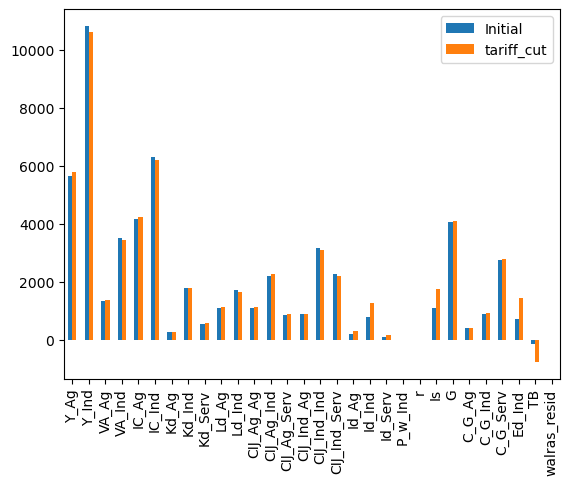

In [29]:
scenario_df[scenario_df.pct_change(axis=1)['tariff_cut'].abs() > 0.01].plot.bar()